# Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from src.utils import check_shape, highlight_top, missing_values_table, save_fig, make_mi_scores, plot_mi_scores
from src.preprocessing import clean_property_type, clean_tenure, fill_missing_values, update_data, drop_columns, create_features

In [44]:
pd.set_option('display.max_columns', None)

In [45]:
data_dir = Path("./raw_data/")
img_dir = Path("./images/")

In [46]:
df_train = pd.read_csv("clean_data/df_train_eda.csv", index_col=0)
df_test = pd.read_csv(Path(data_dir, "test.csv"))

## Initial Mutual Information

In [47]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train_num = df_train.select_dtypes(include=numerics)

In [48]:
X = df_train_num.drop("price", axis=1)
y = df_train_num["price"]

Saving figure mi_score_1


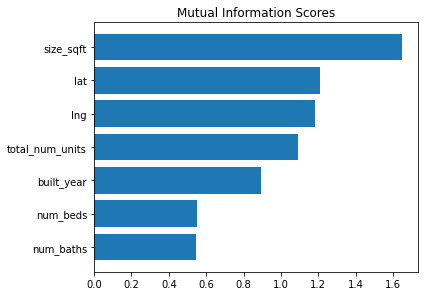

In [49]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores, "mi_score_1", img_dir)

## Feature Engineering

- As shown in above EDA, since there are many categories in ``tenure`` with low count, we can group them together.
- We can compute the number of active years by subtracting ``built_year`` from current year
- We can target encode ``planning_area`` by replacing the values with the mean price 
- We perform one hot encoding on ``tenure`` and ``property_type``
- In our test set, we have one planning area "Boon Lay" that is not present in our training set. As a result, we wont be able to target encode the "Boon Lay". We know that "Boon Lay" is near "Jurong West" so we will impute that value instead

In [50]:
df_train_preproc = create_features(df_train)
df_train_preproc = df_train_preproc.drop(["planning_area"], axis=1)
df_train_preproc.to_csv("clean_data/train_preproc.csv")

In [51]:
df_train_preproc.head()

,num_beds,num_baths,size_sqft,total_num_units,lat,lng,price,active_years,planning_area_density,remaining_lease,mean_subzone_price,mean_subzone_sqft,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,3.0,2.0,1115,116.00000,1.414399,103.837196,514500.0,34.0,15290.636281,65.0,6.658635e+05,1125.152941,1063.446642,1244.961765,1.148675e+06,5.0,223.0,6.595184e+05,0.573567,2.0,1,0
1,4.0,2.0,1575,375.36085,1.372597,103.875625,995400.0,30.0,12981.843721,69.0,1.719814e+06,1928.827586,1063.446642,2582.707317,3.799670e+06,6.0,262.5,6.595184e+05,1.728895,3.0,1,0
2,4.0,6.0,3070,56.00000,1.298773,103.895798,8485000.0,0.0,7535.378473,999.0,4.642224e+06,2152.425743,1179.143997,1806.595166,3.889591e+06,10.0,307.0,2.966084e+06,1.315256,5.0,0,1
3,3.0,2.0,958,638.00000,1.312364,103.803271,2626000.0,-1.0,5513.897301,1000.0,2.757134e+06,999.216535,1179.143997,2568.777256,5.952523e+06,5.0,191.6,2.966084e+06,0.723885,4.0,0,1
4,2.0,1.0,732,351.00000,1.273959,103.843635,1764000.0,-4.0,920.930181,103.0,3.502766e+06,1149.516667,1179.143997,1650.031397,4.988207e+06,3.0,244.0,2.966084e+06,0.370022,16.0,1,0


In [65]:
missing_values_table(df_train_preproc)

Your selected dataframe has 22 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices

In [53]:
X = df_train_preproc.drop("price", axis=1)
y = df_train_preproc["price"]

Saving figure mi_score_2


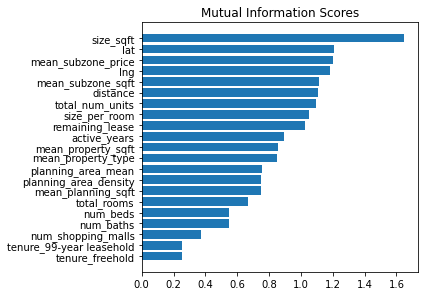

In [54]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores, "mi_score_2", img_dir)

- Since size_sqft is highly informative, we will create more features with it.

In [68]:
df_test_preproc = clean_property_type(df_test)
df_test_preproc = clean_tenure(df_test_preproc)
df_test_preproc = fill_missing_values(df_test_preproc)
df_test_preproc = update_data(df_test_preproc)
df_test_preproc = create_features(df_test_preproc)
df_test_preproc = drop_columns(df_test_preproc)

In [69]:
# since all values will be the same, doesn't matter if we take max
jurong_west_price_mean = df_test_preproc[df_test_preproc["planning_area"] == "jurong west"]["planning_area_mean"].max()
df_test_preproc["planning_area_mean"] = np.where(df_test_preproc["planning_area"]=="boon lay",  jurong_west_price_mean, df_test_preproc["planning_area_mean"])
df_test_preproc = df_test_preproc.drop(["planning_area"], axis=1)
df_test_preproc.to_csv("clean_data/test_preproc.csv")

In [70]:
missing_values_table(df_test_preproc)

Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values
